In [49]:
!pip install ta --quiet

In [71]:
# Imports

# Essential
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import joblib

# Sci-kit
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA

In [51]:
## Get data and create features

# Time range: past year
end_date = datetime.now()
start_date = end_date - timedelta(days=3650)

# Download data and include adjusted close
amzn_data = yf.download("AMZN", start=start_date, end=end_date, auto_adjust=False)

# Check available columns
# print("Columns:", amzn_data.columns)

# Get PE ratio from metadata
amzn = yf.Ticker("AMZN")
pe_ratio = amzn.info.get('trailingPE', None)

# Create a Series for the PE ratio with the same date index as amzn_data
pe_series = pd.Series(pe_ratio, index=amzn_data.index)

# Combine the PE ratio Series with the historical data
amzn_data['PE_Ratio'] = pe_series

# Daily Volatility (using 7-day rolling standard deviation of log returns)
amzn_data['Log_Return'] = (amzn_data['Adj Close'] / amzn_data['Adj Close'].shift(1)).apply(np.log)
amzn_data['Volatility_7d'] = amzn_data['Log_Return'].rolling(window=7).std()

#MA past week
amzn_data['MA_7'] = amzn_data['Adj Close'].rolling(window=7).mean()
#MA past month
amzn_data['MA_30'] = amzn_data['Adj Close'].rolling(window=30).mean()
#MA past year
amzn_data['MA_365'] = amzn_data['Adj Close'].rolling(window=365).mean()

amzn_data['Pct_Change'] = amzn_data['Adj Close'].pct_change()

# Remove multi-index
amzn_data.columns = [col[0] if isinstance(col, tuple) else col for col in amzn_data.columns]
print("Columns:", amzn_data.columns)

[*********************100%***********************]  1 of 1 completed


Columns: Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'PE_Ratio',
       'Log_Return', 'Volatility_7d', 'MA_7', 'MA_30', 'MA_365', 'Pct_Change'],
      dtype='object')


In [52]:
amzn_data.describe()

,Adj Close,Close,High,Low,Open,Volume,PE_Ratio,Log_Return,Volatility_7d,MA_7,MA_30,MA_365,Pct_Change
count,2514.000000,2514.000000,2514.000000,2514.000000,2514.000000,2.514000e+03,2.514000e+03,2513.000000,2507.000000,2508.000000,2485.000000,2150.000000,2513.000000
mean,107.406705,107.406705,108.668388,106.073069,107.428583,7.515756e+07,3.334900e+01,0.000862,0.017873,107.415311,107.470070,106.608167,0.001075
std,55.233206,55.233206,55.907148,54.534817,55.253361,3.951186e+07,5.685473e-14,0.020642,0.010531,55.088667,54.605912,44.146315,0.020676
min,20.955000,20.955000,21.136000,20.727501,21.030001,1.500750e+07,3.334900e+01,-0.151398,0.001943,21.296714,21.397033,30.563562,-0.140494
25%,54.795124,54.795124,55.142500,52.981500,53.747500,4.976282e+07,3.334900e+01,-0.008874,0.010573,54.030982,54.883933,71.147458,-0.008834
50%,97.529499,97.529499,98.570999,96.162750,97.419998,6.460325e+07,3.334900e+01,0.001109,0.015383,97.382857,97.311366,115.425362,0.001110
75%,158.106125,158.106125,159.930752,156.224998,158.328247,8.926850e+07,3.334900e+01,0.011502,0.022288,157.901393,158.421949,145.959011,0.011568
max,242.059998,242.059998,242.520004,238.029999,239.020004,4.381880e+08,3.334900e+01,0.126949,0.067685,237.695714,230.223333,186.564932,0.135359


In [53]:
amzn_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2514 entries, 2015-05-04 to 2025-04-30
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Adj Close      2514 non-null   float64
 1   Close          2514 non-null   float64
 2   High           2514 non-null   float64
 3   Low            2514 non-null   float64
 4   Open           2514 non-null   float64
 5   Volume         2514 non-null   int64  
 6   PE_Ratio       2514 non-null   float64
 7   Log_Return     2513 non-null   float64
 8   Volatility_7d  2507 non-null   float64
 9   MA_7           2508 non-null   float64
 10  MA_30          2485 non-null   float64
 11  MA_365         2150 non-null   float64
 12  Pct_Change     2513 non-null   float64
dtypes: float64(12), int64(1)
memory usage: 275.0 KB


In [54]:
# Slice original dataframe to get 1095 dayd (3 years) of data

# 3 years of data
days = 1095
amzn_data = amzn_data.iloc[-(days+1):-1]

X = amzn_data
print("X.shape:", X.shape)

y = amzn_data['Adj Close'].shift(-1)

print("y.shape:", y.shape)

print(X.tail)
print(y.tail)

X.shape: (1095, 13)
y.shape: (1095,)
<bound method NDFrame.tail of              Adj Close       Close        High         Low        Open  \
Date                                                                     
2020-12-17  161.804001  161.804001  163.175507  161.050003  162.500000   
2020-12-18  160.082504  160.082504  162.470993  158.580002  162.199493   
2020-12-21  160.309006  160.309006  161.348495  158.300003  160.000504   
2020-12-22  160.326004  160.326004  161.100006  159.003998  160.141998   
2020-12-23  159.263504  159.263504  160.506500  159.208496  160.250000   
...                ...         ...         ...         ...         ...   
2025-04-23  180.600006  180.600006  187.380005  180.190002  183.449997   
2025-04-24  186.539993  186.539993  186.740005  180.179993  180.919998   
2025-04-25  188.990005  188.990005  189.940002  185.490005  187.619995   
2025-04-28  187.699997  187.699997  190.220001  184.889999  190.110001   
2025-04-29  187.389999  187.389999  188.02000

In [93]:
# Prepare feature matrix such that for each day, input variables are data from all features for last 30 days

X = []
y = []
print(len(amzn_data))

features = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'Log_Return', 'Pct_Change', 'MA_7', 'MA_30', 'MA_365', 'Volatility_7d', 'PE_Ratio']

time_steps = 7  # Lookback period
for i in range(time_steps, len(amzn_data)):
    # the line of code below adds all the features from the lookback start to the day before the current
    X.append(amzn_data[features].iloc[i-time_steps:i].values)  # Use NumPy slicing instead of iloc
    # the line below adds only the 'closing price' feature to y on the currnet day that it's trying to predict
    y.append(amzn_data['Close'].iloc[i])

1095


In [94]:
# Convert feature and target matrices to numpy arrays
X, y = np.array(X), np.array(y)

# Flatten 3D feature matrix to 2D matrix (such that data for each "day" is one row instead of a 2D matrix)
X_flat = X.reshape(X.shape[0], -1)

In [95]:
# Split the data using train_test split
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)

(870, 91)
(870,)


In [96]:
# Scale the data

scale = StandardScaler()
# scale both the training and test data using the fitted scaler.
X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)
# X_test = scale.fit_transform(X_test)

# Reshape `y_train` into 2D array, and `y_test` into 2D array
y_2d_train = y_train.reshape(y_train.shape[0], 1)
y_2d_test = y_test.reshape(y_test.shape[0], 1)

print("X_train.shape:", X_train.shape)
print("y_2d_train.shape:", y_2d_train.shape)

X_train.shape: (870, 91)
y_2d_train.shape: (870, 1)


In [97]:
# Appending a column of ones to X_train and X_test for intercept term

ones = np.ones((X_train.shape[0], 1))
X_train_1 = np.hstack((ones, X_train))

ones = np.ones((X_test.shape[0], 1))
X_test_1 = np.hstack((ones, X_test))

print("The trainng data has dimensions: ", X_train_1.shape)
print("The trainng data has dimensions: ", X_test_1.shape)

The trainng data has dimensions:  (870, 92)
The trainng data has dimensions:  (218, 92)


In [98]:
# Train model with 6 different ridge regularization values

# Initalize range from 10e-3 to 10e2
reg_params = np.logspace(-3, 2, num=6)

pred_ridge = []

# Train and test model with each regularization value
for a in reg_params[::-1]:
    # Initialize linear regression model with regularization value
    ridge_model = Ridge(alpha=a)

    # Fit model
    ridge_model.fit(X_train_1, y_2d_train)

    # Predict
    y_pred = ridge_model.predict(X_test_1)
    pred_ridge.append(y_pred)

    # Evaluate
    mse = mean_squared_error(y_2d_test, y_pred)
    print("Mean Squared Error (a=, ", a, "):", mse)


Mean Squared Error (a=,  100.0 ): 9.894223863596142
Mean Squared Error (a=,  10.0 ): 9.31260201856008
Mean Squared Error (a=,  1.0 ): 9.251797795300837
Mean Squared Error (a=,  0.1 ): 9.367376707349532
Mean Squared Error (a=,  0.01 ): 9.578739576299924
Mean Squared Error (a=,  0.001 ): 9.791489827771944


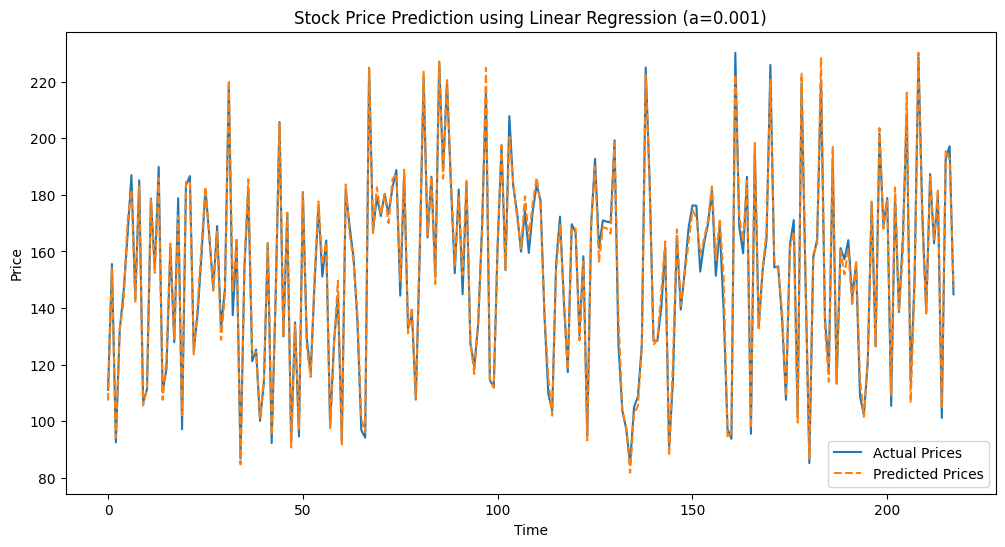

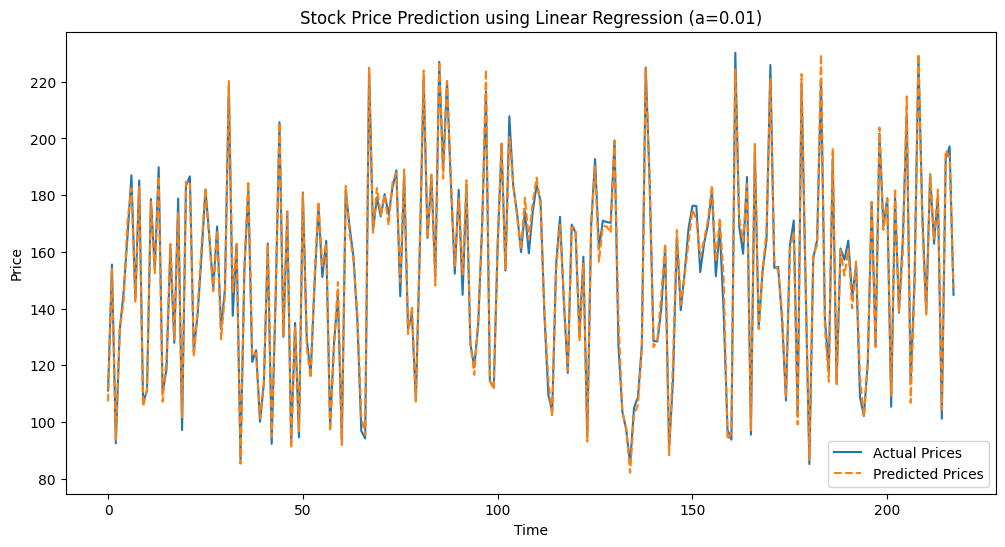

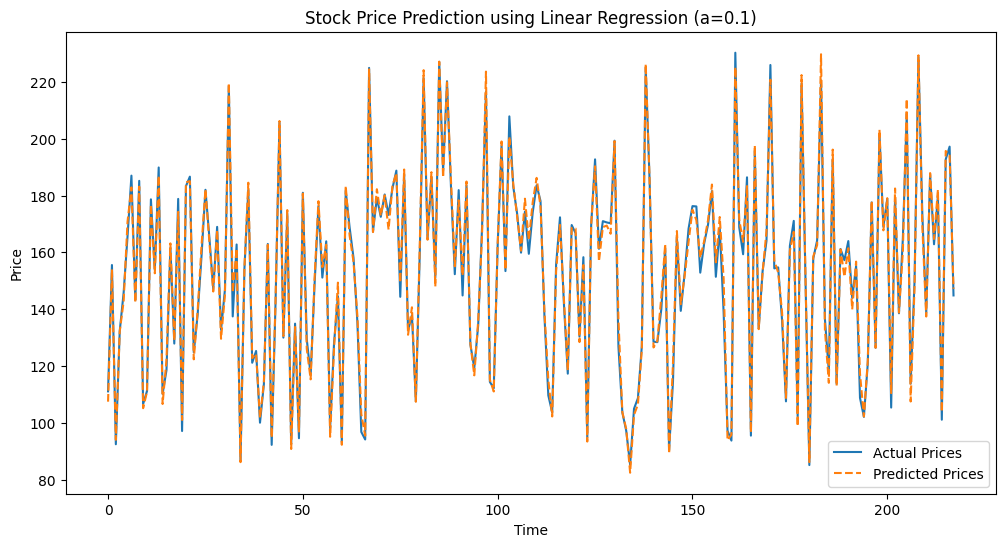

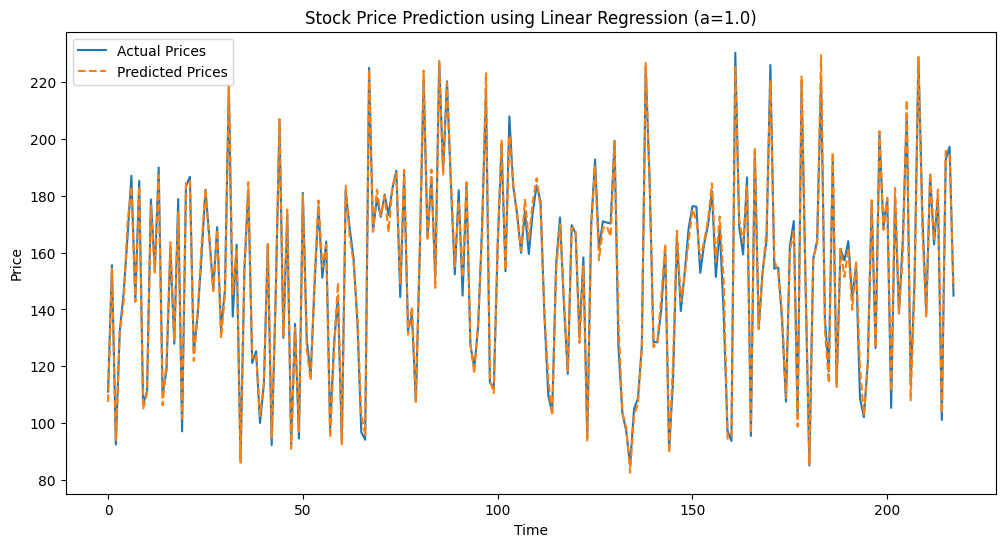

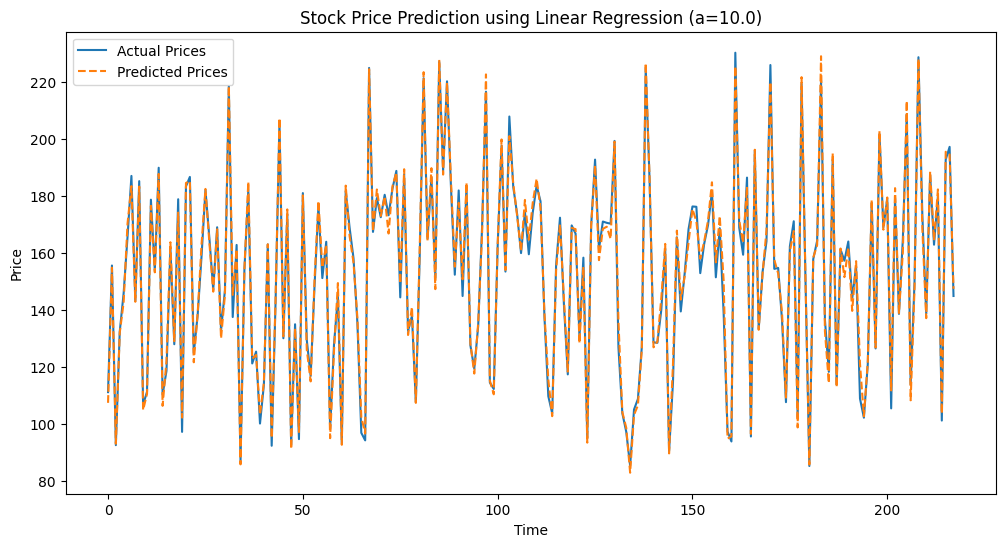

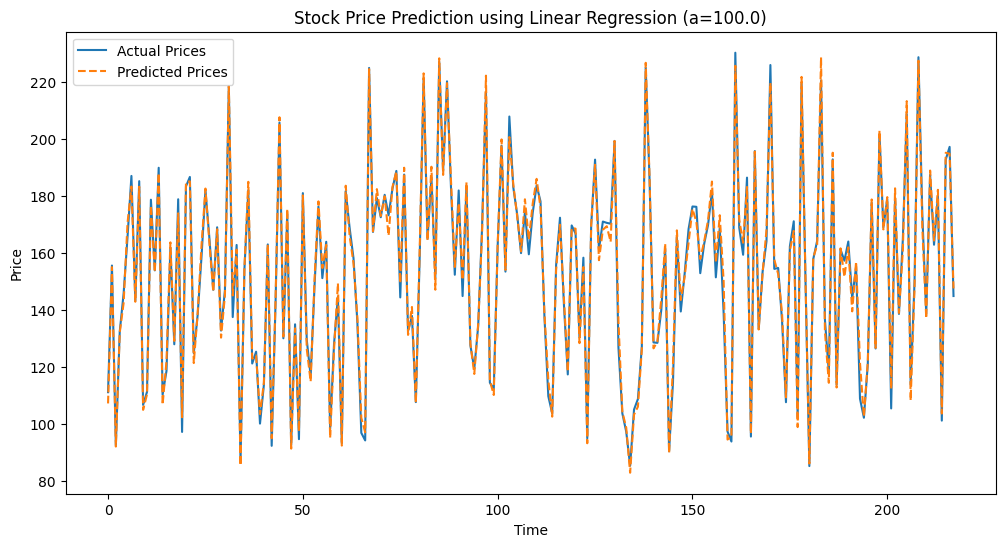

In [99]:
# Plot the predictions with the different regularization values
for i in range(len(reg_params)):
    plt.figure(figsize=(12, 6))
    plt.plot(y_test, label="Actual Prices")
    plt.plot(pred_ridge[i], label="Predicted Prices", linestyle='--')
    plt.title(f'Stock Price Prediction using Linear Regression (a={reg_params[i]})')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

In [106]:
# Perform 3 different polynomial transformations

# Prepare feature transformations for degree 2, 3, and 4 polynomial on train and test sets
poly2 = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly2 = poly2.fit_transform(X_train_1)
X_test_poly2 = poly2.fit_transform(X_test_1)

poly3 = PolynomialFeatures(degree=3, include_bias=False)
X_train_poly3 = poly3.fit_transform(X_train_1)
X_test_poly3 = poly3.fit_transform(X_test_1)

poly4 = PolynomialFeatures(degree=3, include_bias=False)
X_train_poly4 = poly4.fit_transform(X_train_1)
X_test_poly4 = poly4.fit_transform(X_test_1)

In [107]:
# Train and test model with each feature transformation

feature_transformations_train_poly = [X_train_poly2, X_train_poly3, X_train_poly4]
feature_transformations_test_poly = [X_test_poly2, X_test_poly3, X_test_poly4]

pred_poly = []

for i in range(len(feature_transformations_train_poly)):
    # Initialize linear regression model
    ridge_model = Ridge(alpha=0)

    # Fit model
    ridge_model.fit(feature_transformations_train_poly[i], y_2d_train)

    # Predict
    y_pred = ridge_model.predict(feature_transformations_test_poly[i])
    pred_poly.append(y_pred)

    # Evaluate
    mse = mean_squared_error(y_2d_test, y_pred)
    print("Mean Squared Error (degree=, ", i+2, "):", mse)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:252: LinAlgWarning: Ill-conditioned matrix (rcond=1.89057e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


Mean Squared Error (degree=,  2 ): 221.74697162931963


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:252: LinAlgWarning: Ill-conditioned matrix (rcond=8.85879e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


Mean Squared Error (degree=,  3 ): 310.5460604254695
Mean Squared Error (degree=,  4 ): 310.5460604254695


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:252: LinAlgWarning: Ill-conditioned matrix (rcond=8.85879e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


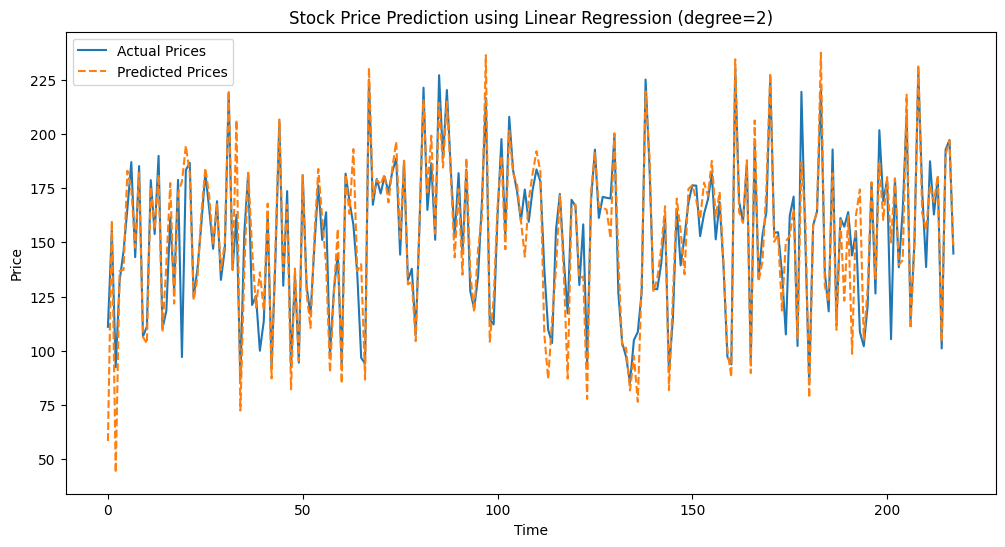

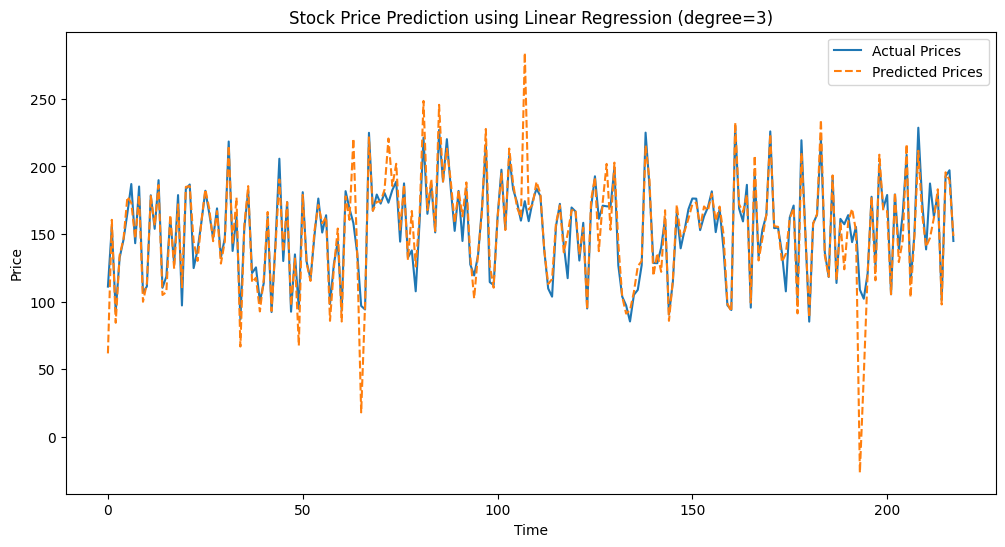

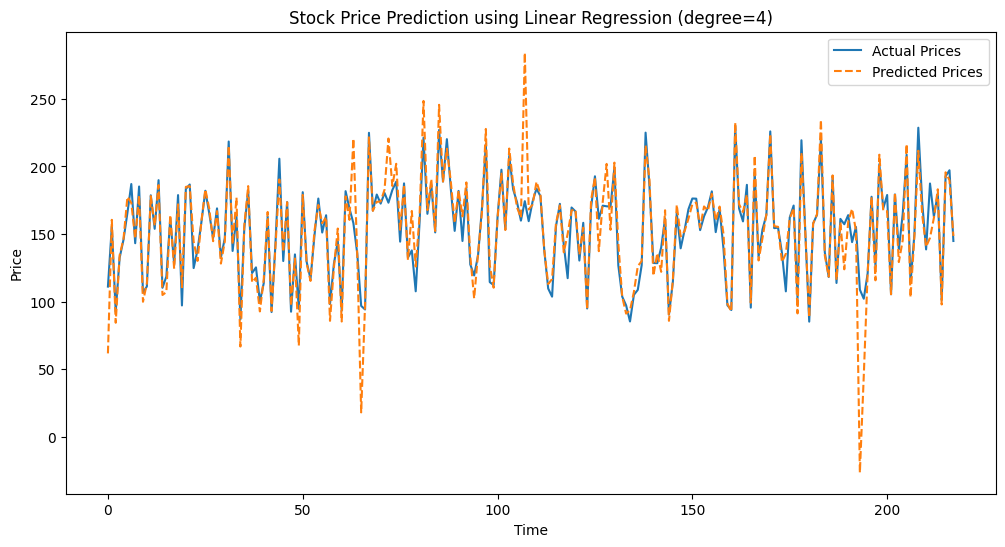

In [110]:
# Plot the predictions with different polynomial tranformations

for i in range(len(pred_poly)):
    plt.figure(figsize=(12, 6))
    plt.plot(y_test, label="Actual Prices")
    plt.plot(pred_poly[i], label="Predicted Prices", linestyle='--')
    plt.title(f'Stock Price Prediction using Linear Regression (degree={i+2})')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

In [119]:
# Perform 4 different PCA transformations

# Initialize PCA
pca1 = PCA(n_components=1)  # Keep 2 principal components
X_train_pca1 = pca1.fit_transform(X_train_1)  # Fit and transform the training data
X_test_pca1 = pca1.transform(X_test_1)  # Only transform the test data

pca2 = PCA(n_components=2)  # Keep 2 principal components
X_train_pca2 = pca2.fit_transform(X_train_1)  # Fit and transform the training data
X_test_pca2 = pca2.transform(X_test_1)  # Only transform the test data

pca3 = PCA(n_components=3)  # Keep 3 principal components
X_train_pca3 = pca3.fit_transform(X_train_1)
X_test_pca3 = pca3.transform(X_test_1)

pca4 = PCA(n_components=4)  # Keep 4 principal components
X_train_pca4 = pca4.fit_transform(X_train_1)
X_test_pca4 = pca4.transform(X_test_1)

pca5 = PCA(n_components=5)  # Keep 5 principal components
X_train_pca5 = pca5.fit_transform(X_train_1)
X_test_pca5 = pca5.transform(X_test_1)

pca6 = PCA(n_components=6)  # Keep 6 principal components
X_train_pca6 = pca6.fit_transform(X_train_1)
X_test_pca6 = pca6.transform(X_test_1)

pca7 = PCA(n_components=7)  # Keep 7 principal components
X_train_pca7 = pca7.fit_transform(X_train_1)
X_test_pca7 = pca7.transform(X_test_1)

# You can also determine the number of components to keep by the explained variance ratio
# For example, to retain 95% of the variance
pca95 = PCA(n_components=0.95)  # Retain 95% variance
X_train_pca95 = pca95.fit_transform(X_train_1)
X_test_pca95 = pca95.transform(X_test_1)

In [121]:
# Train and test model with each pca transformation

feature_transformations_train_pca = [X_train_pca1, X_train_pca2, X_train_pca3, X_train_pca4, X_train_pca5, X_train_pca6, X_train_pca7, X_train_pca95]
feature_transformations_test_pca = [X_test_pca1, X_test_pca2, X_test_pca3, X_test_pca4, X_test_pca5, X_test_pca6, X_test_pca7, X_test_pca95]

pred_pca = []

for i in range(len(feature_transformations_train_pca)):
    # Initialize linear regression model
    ridge_model = Ridge(alpha=0)

    # Fit model
    ridge_model.fit(feature_transformations_train_pca[i], y_2d_train)

    # Predict
    y_pred = ridge_model.predict(feature_transformations_test_pca[i])
    pred_pca.append(y_pred)

    # Evaluate
    mse = mean_squared_error(y_2d_test, y_pred)
    if (i < 7):
        print("Mean Squared Error (p components =", i+1, "):", mse)
    elif (i == 7):
        print("Mean Squared Error (95% variance)=", mse)

Mean Squared Error (p components = 1 ): 40.20215735946765
Mean Squared Error (p components = 2 ): 37.37813949692969
Mean Squared Error (p components = 3 ): 30.522240023420128
Mean Squared Error (p components = 4 ): 25.093150508230988
Mean Squared Error (p components = 5 ): 25.169543936801322
Mean Squared Error (p components = 6 ): 25.053931683295698
Mean Squared Error (p components = 7 ): 25.3647011363592
Mean Squared Error (95% variance)= 10.743857586097274


In [ ]:
# Plot the predictions with different PCA transformations

for i in range(len(pred_pca)):
    plt.figure(figsize=(12, 6))
    plt.plot(y_test, label="Actual Prices")
    plt.plot(pred_poly[i], label="Predicted Prices", linestyle='--')
    if (i < 3):
        print("Mean Squared Error (p components =", i+1, "):", mse)
    elif (i == 3):
        print("Mean Squared Error (95% variance)=", mse)
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

In [103]:
# Train model with all regularization values for all four PCA transformations

for i in range(len(feature_transformations_train_pca)):
    for a in reg_params:
        # Initialize linear regression model
        ridge_model = Ridge(alpha=a)

        # Fit model
        ridge_model.fit(feature_transformations_train_pca[i], y_2d_train)

        # Predict
        y_pred = ridge_model.predict(feature_transformations_test_pca[i])
        pred_ridge.append(y_pred)

        # Evaluate
        mse = mean_squared_error(y_2d_test, y_pred)
        if (i == 0):
            print("Mean Squared Error (no PCA,", end=' ')
        elif (i < 4):
            print("Mean Squared Error (p components,", i+1, "):", end=' ')
        elif (i == 4):
            print("Mean Squared Error (95% variance,", end=' ')
        print("a =", a, "):", mse)

Mean Squared Error (no PCA, a = 0.001 ): 9.791489827771944
Mean Squared Error (no PCA, a = 0.01 ): 9.578739576299924
Mean Squared Error (no PCA, a = 0.1 ): 9.367376707349532
Mean Squared Error (no PCA, a = 1.0 ): 9.251797795300837
Mean Squared Error (no PCA, a = 10.0 ): 9.31260201856008
Mean Squared Error (no PCA, a = 100.0 ): 9.894223863596142
Mean Squared Error (p components, 2 ): a = 0.001 ): 37.378139236954105
Mean Squared Error (p components, 2 ): a = 0.01 ): 37.37813714552812
Mean Squared Error (p components, 2 ): a = 0.1 ): 37.378116236974456
Mean Squared Error (p components, 2 ): a = 1.0 ): 37.37790772202979
Mean Squared Error (p components, 2 ): a = 10.0 ): 37.37587959784262
Mean Squared Error (p components, 2 ): a = 100.0 ): 37.36126721274304
Mean Squared Error (p components, 3 ): a = 0.001 ): 30.52224096301208
Mean Squared Error (p components, 3 ): a = 0.01 ): 30.522235993528053
Mean Squared Error (p components, 3 ): a = 0.1 ): 30.52218631655979
Mean Squared Error (p compone